![GCAT | Genomes for Life](images/logo-GCAT.png)

# Filter hip and waist

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import *
%matplotlib inline 

## Helper functions

### Joint plots

In [2]:
from scipy.stats import kendalltau
import seaborn as sns

def jointplot(a, b, ds):    
    sns.set(style="ticks")
    sns.jointplot(ds[a], ds[b], color="#4CB391")

def male(ds):
    return ds[ds['Admin.Participant.gender'] == 'MALE']
    
def female(ds):
    return ds[ds['Admin.Participant.gender'] == 'FEMALE']

## Load tables

- Participants
- CinturaCadera

In [3]:
cintura = pd.read_csv("/home/labs/dnalab/share/lims/R/gcat-cohort/output/export/CinturaCadera/data.csv")
participants = pd.read_csv("/home/labs/dnalab/share/lims/R/gcat-cohort/output/export/Participants/data.csv")

all = participants
all = pd.merge(all, cintura, on=['entity_id'])

## Select variables of interest

In [4]:
columns = [
    'entity_id',
    '1_Cadera',
    '2_Cadera',
    'CALC_AVG_CADERA',
    '1_Cintura',
    '2_Cintura',
    'CALC_AVG_CINTURA',
    'Admin.Participant.gender'
]

all = all.ix[:,columns]
all = all.dropna()

## Explore hip and waist distributions

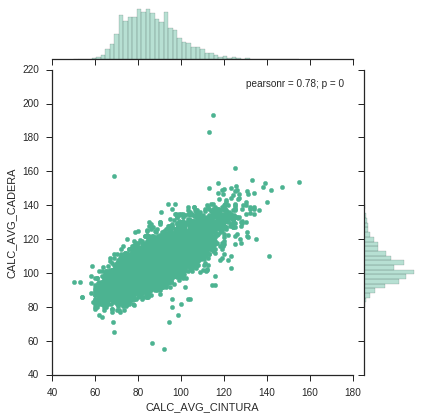

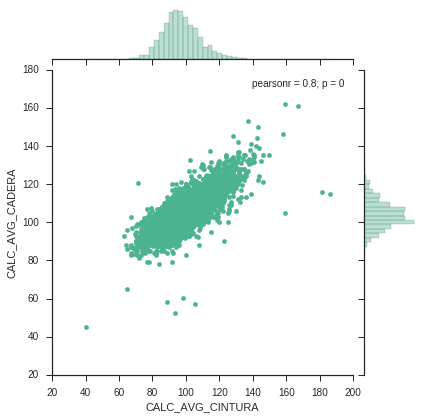

In [5]:
ds = all.copy()

jointplot('CALC_AVG_CINTURA', 'CALC_AVG_CADERA', female(ds))
jointplot('CALC_AVG_CINTURA', 'CALC_AVG_CADERA', male(ds))

## Hip

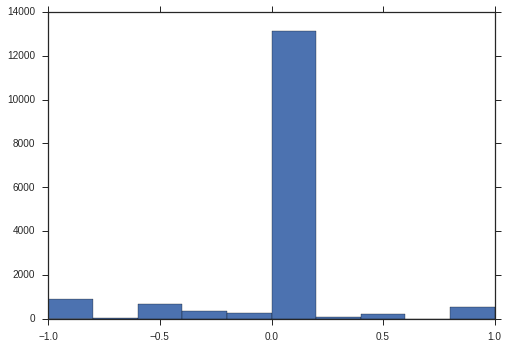

In [6]:
plt.hist(ds['1_Cintura'] - ds['2_Cintura'])
plt.show()

## Weight

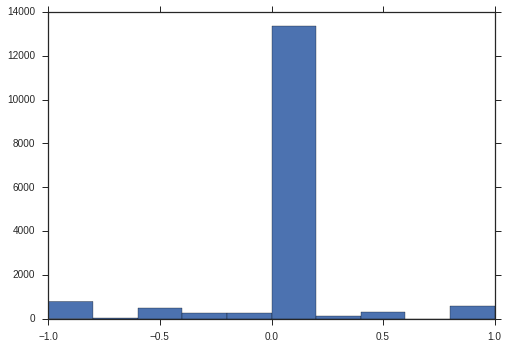

In [7]:
plt.hist(ds['1_Cadera'] - ds['2_Cadera'])
plt.show()

## Outlier model

In [8]:
from sklearn import svm

def svn_outliers(ds, columns, outcome):
    X = ds[columns]
    # fit the model
    clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
    clf.fit(X)
    ds[outcome] = abs(clf.decision_function(X))
    ds = ds.sort_values([outcome], ascending=False)
    return ds

def plotThreshold(a, b, c, title, xlabel, ylabel):
    fig, ax = plt.subplots()
    colors = plt.cm.coolwarm(c)
    ax.scatter(a, b, c=colors)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.savefig('figures/wh_3.svg')
    plt.show()
    
def plot_svn(ds, columns, outcome):
    ds = ds.dropna(subset = columns)
    ds = svn_outliers(ds, columns, outcome)
    plotThreshold(
        ds[columns[0]],
        ds[columns[1]],
        ds[outcome],
        'Hip & Waist OneClassSVM error',
        'Cintura',
        'Cadera',
    )
    return ds

### Female outliers

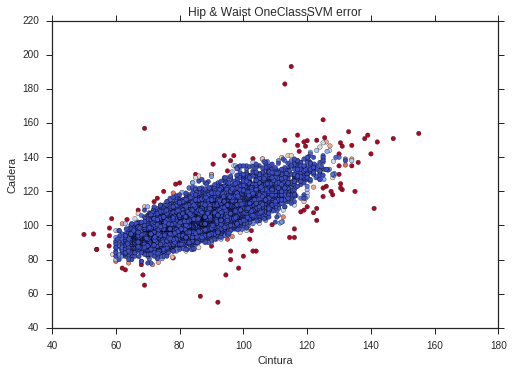

,entity_id,CALC_AVG_CINTURA,CALC_AVG_CADERA,ERROR_SVN_MEASURES
14263,=E00251629573721,69.0,157.00,3.650091
4341,=E00251510705521,141.0,110.00,3.650089
2423,=E00251515061421,113.0,183.00,3.650072
13150,=E00251625175121,115.0,193.25,3.650072
7892,=E00251439607521,125.0,162.00,3.650061
8304,=E00251531885921,155.0,154.00,3.649415
664,=E00251515073621,92.0,55.00,3.635826
12721,=E00251626616721,86.5,58.50,3.635826
11313,=E00251615135821,69.0,65.00,3.623432
9011,=E00251531381621,94.5,71.00,3.609086


In [9]:
ds_female = plot_svn(female(ds), ['CALC_AVG_CINTURA', 'CALC_AVG_CADERA'], 'ERROR_SVN_MEASURES')
ds_female[['entity_id', 'CALC_AVG_CINTURA', 'CALC_AVG_CADERA', 'ERROR_SVN_MEASURES']][:10]

### Set female outliers threshold

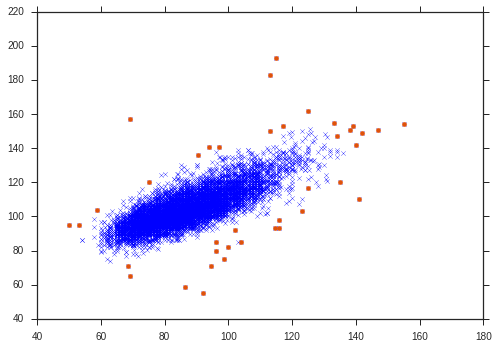

In [10]:
ds_female_outliers = ds_female[ds_female['ERROR_SVN_MEASURES'] > 2.58]
plt.scatter(ds_female['CALC_AVG_CINTURA'], ds_female['CALC_AVG_CADERA'], marker='x')
plt.scatter(ds_female_outliers['CALC_AVG_CINTURA'], ds_female_outliers['CALC_AVG_CADERA'], marker='o', color='#DE510D')
plt.show()

### Male outliers

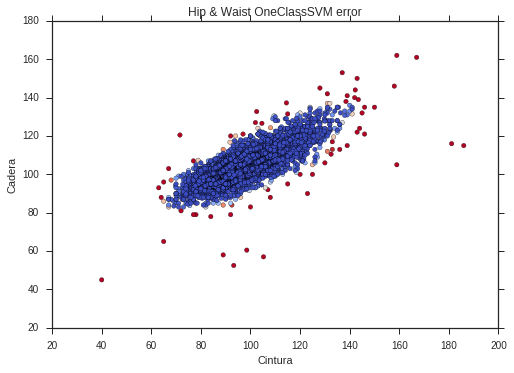

,entity_id,CALC_AVG_CINTURA,CALC_AVG_CADERA,ERROR_SVN_MEASURES
11574,=E00251617640821,40.00,45.0,2.915272
5705,=E00251514167521,159.00,105.0,2.915272
8299,=E00251518876622,65.00,65.0,2.915272
2478,=E00251515324521,71.55,120.5,2.915272
2245,=E00251510656521,158.00,146.0,2.915272
12988,=E00251624172621,123.00,90.0,2.915086
4351,=E00251510702421,167.00,161.0,2.913769
7076,=E00251531548021,159.00,162.0,2.913769
5991,=E00251529260221,105.25,57.0,2.912187
12713,=E00251626616421,98.50,60.5,2.912017


In [11]:
ds_male = plot_svn(male(ds), ['CALC_AVG_CINTURA', 'CALC_AVG_CADERA'], 'ERROR_SVN_MEASURES')
ds_male[['entity_id', 'CALC_AVG_CINTURA', 'CALC_AVG_CADERA', 'ERROR_SVN_MEASURES']][:10]

### Set male outliers threshold

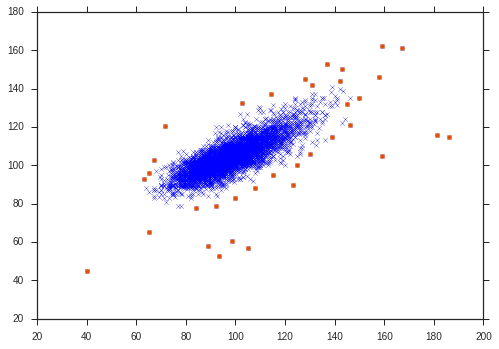

In [12]:
ds_male_outliers = ds_male[ds_male['ERROR_SVN_MEASURES'] > 2.04]
plt.scatter(ds_male['CALC_AVG_CINTURA'], ds_male['CALC_AVG_CADERA'], marker='x')
plt.scatter(ds_male_outliers['CALC_AVG_CINTURA'], ds_male_outliers['CALC_AVG_CADERA'], marker='o', color='#DE510D')
plt.show()

### Remove outliers

In [13]:
outliers = ds_male_outliers.entity_id.append(ds_female_outliers.entity_id)
ds = ds[~ds.entity_id.isin(outliers)]

## WHR

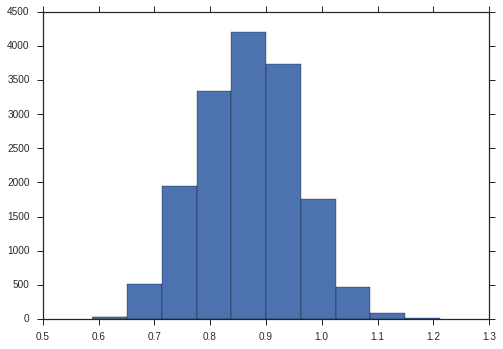

In [14]:
def WHR(waist, hip):
    return waist/hip

ds['WHR'] = WHR(ds['CALC_AVG_CINTURA'], ds['CALC_AVG_CADERA'])

plt.hist(ds['WHR'])
plt.show()

## Write errors

In [17]:
outliers = list(set(all.index.values) - set(ds.index.values))
errors = all.iloc[outliers][['entity_id', 'CALC_AVG_CINTURA', 'CALC_AVG_CADERA']]
errors.to_csv('../output/check/whr/outliers.csv', index=False)

## Write inferred measures

In [18]:
ds[['entity_id', 'CALC_AVG_CINTURA', 'CALC_AVG_CADERA', 'WHR']].to_csv('../output/check/whr/data.csv', index=False)